# Kirchhoff migration

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.utils.wavelets  import *

## Model, geometry, and data

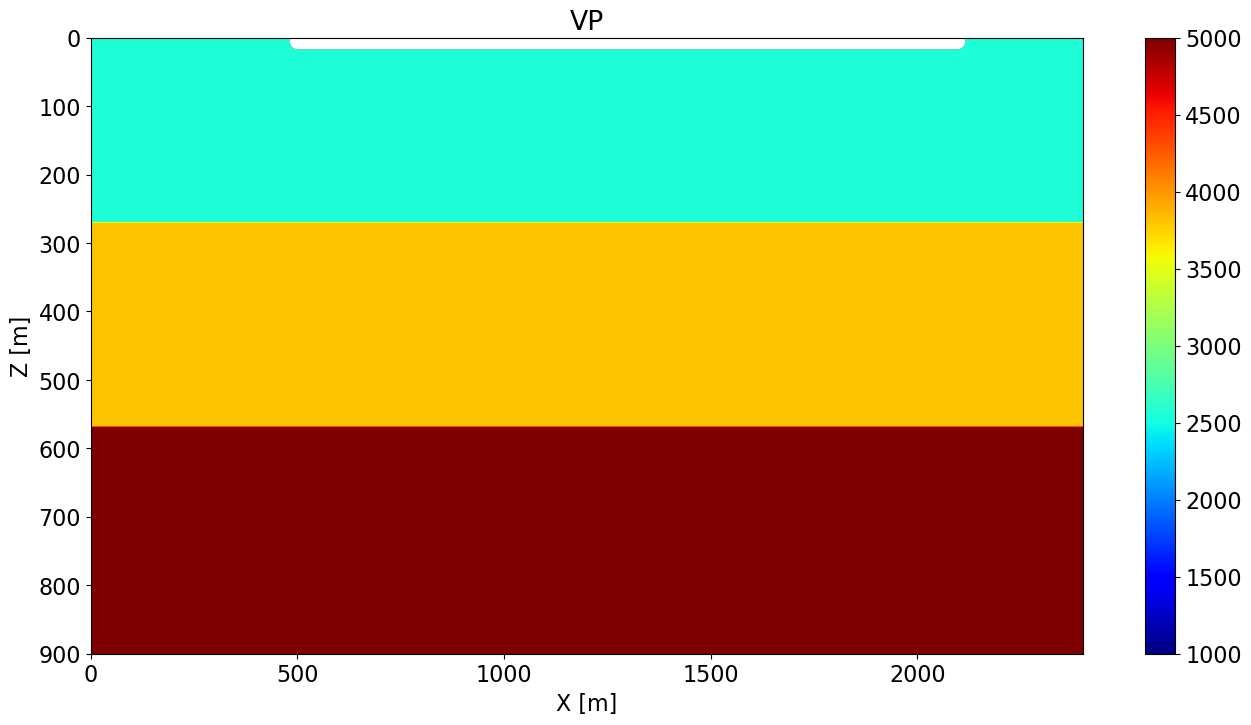

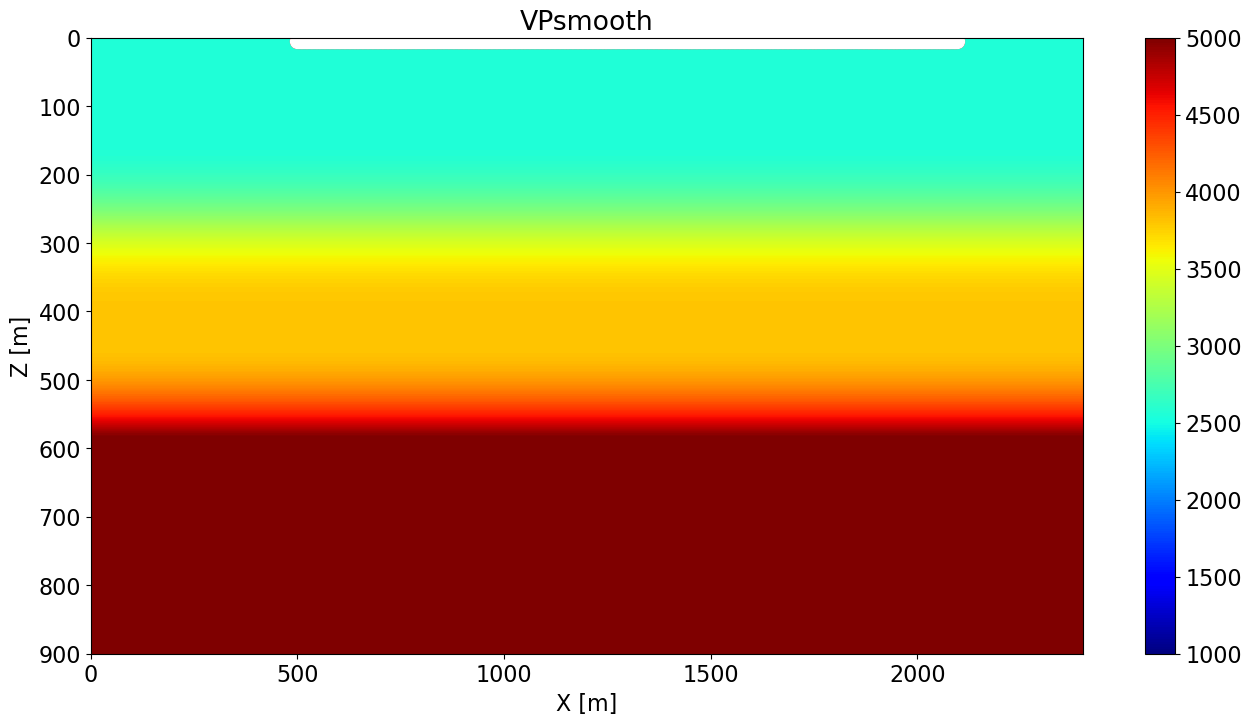

In [4]:
# Load from input file
inputdata = np.load('/home/wangn0e/2023-2024/research/Devito_modelling/SWD/MDD_for_SWD_data_constantmodel_noise/data/niose_for_cc_stacking.npz')

# Receivers
r = inputdata['r']
dr = r[0, 1]-r[0, 0]
nr = r.shape[1]

# Sources
s = inputdata['s']
ds = s[1, 1]-s[1, 0]
ns = s.shape[1]

# models
vel = inputdata['vel'].T

# Axes
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]
nx = x.size
nz = z.size

s = r
ns = nr
ds = dr

# Smooth velocity
nsmooth = 41
smooth = np.ones(nsmooth)/nsmooth
velsm = filtfilt(smooth, 1, filtfilt(smooth, 1, vel).T).T


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')
plt.colorbar(im);

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth')
ax.axis('tight')
plt.colorbar(im);

In [ ]:
d = np.load('data/Rinv_3min_nowav.npy')
d.shape

(400, 400, 1500)

In [ ]:
# 1cc
d_cor = np.load('./GHd_sum_full.npy')
d_cor = d_cor[:, :, d.shape[-1]//2:]

In [75]:
d.shape, d_cor.shape

((400, 400, 1500), (400, 400, 1500))

In [77]:
nt = d.shape[2]
dt = 0.002
t = np.arange(nt)*dt

r = r[:,:-1]
nr = r.shape[1]

s = s[:,:-1]
ns = s.shape[1]

In [ ]:
velocity = vel[0,0]+700
direct_arrival_times = np.zeros((ns, nr))
troff = 0.1

for i in range(nr):
    for j in range(ns):
        # Calculate the Euclidean distance between r[:, i] and s[:, j]
        distance = np.sqrt((r[0, i] - s[0, j])**2 + (r[1, i] - s[1, j] )**2)
        
        # Calculate direct arrival time by dividing distance by velocity
        direct_arrival_times[j, i] = distance / velocity

FirstVSr_off = direct_arrival_times + troff
iFirstVSr_off = np.round(FirstVSr_off/dt).astype(np.int32)        

wr = np.ones((ns, nr, nt))

for ir in range(nr):
    for isrc in range(ns):
        wr[isrc, ir, :iFirstVSr_off[isrc, ir]]=0

d_p = d * wr
dcor_p = d_cor * wr        

In [ ]:
# Create an index grid for sources (is) and receivers (ir)
is_indices = np.arange(ns).reshape(-1, 1)  # Shape (ns, 1, 1)
ir_indices = np.arange(nr).reshape(1, -1)  # Shape (1, nr, 1)
# Expand is_indices and ir_indices to match the shape of p in the first two dimensions only
condition = (ir_indices < is_indices)

# Set values to zero where ir < is, broadcasting along the time dimension (nt)
d_p[condition] = 0
dcor_p[condition] = 0

## Kirchhoff Migration

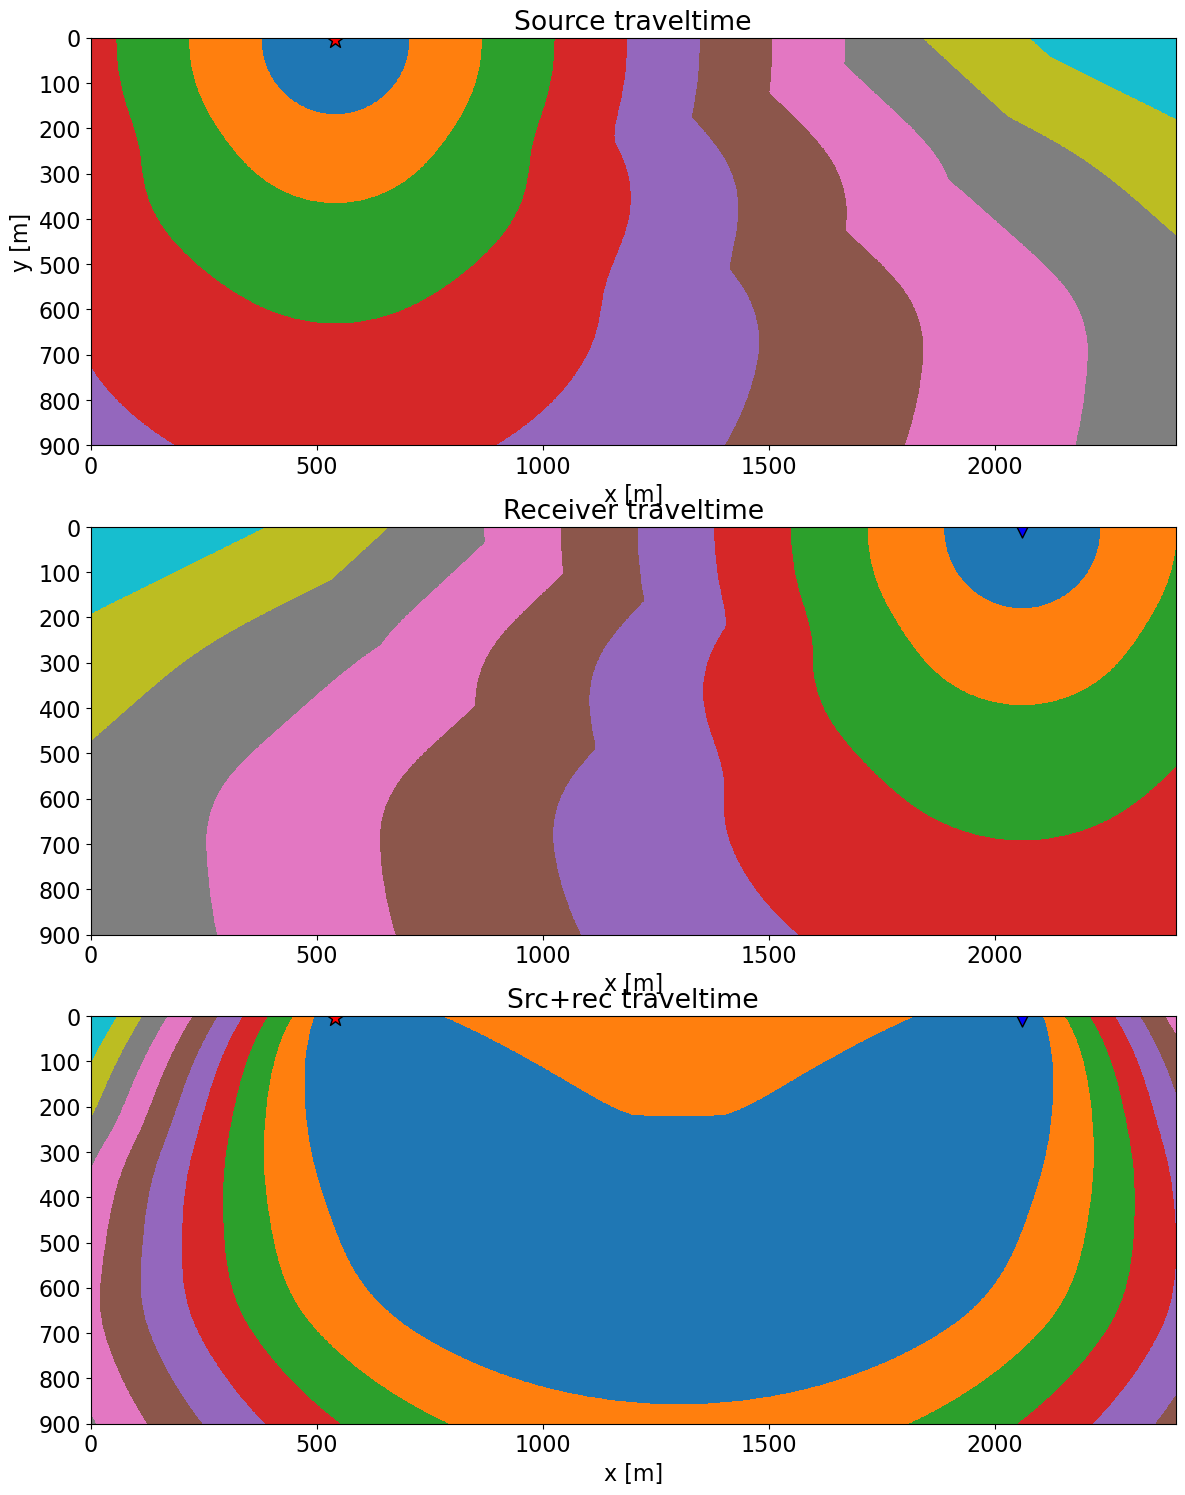

In [ ]:
wav, _, wavc = ricker(t[0:61], 80)
wavc = np.argmax(wav)

KOp = Kirchhoff(z, x, t, s, r, velsm, wav, wavc, dynamic=False,
                mode='eikonal', engine='numba')


fig, axs = plt.subplots(3, 1, sharey=True, figsize=(14, 18))
axs[0].imshow(KOp.trav_srcs[:, 10].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(s[0, 10], s[1, 10], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
axs[1].imshow(KOp.trav_recs[:, -10].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(r[0, -10], r[1, -10], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
axs[2].imshow(KOp.trav_srcs[:, 10].reshape((nx, nz)).T + KOp.trav_recs[:, -10].reshape((nx, nz)).T, 
              cmap='tab10', extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(s[0, 10], s[1, 10], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(r[0, -10], r[1, -10], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0]);

In [95]:
# migration
image = KOp.H * d_p
image = image.reshape(nx, nz)

# artifact removal
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
imagefilt = image - filtfilt(smooth,1,filtfilt(smooth,1,image).T).T

In [82]:
# migration
image_cor = KOp.H * dcor_p
image_cor = image_cor.reshape(nx, nz)

## Visualization

(0.0, 2400.0, 900.0, 0.0)

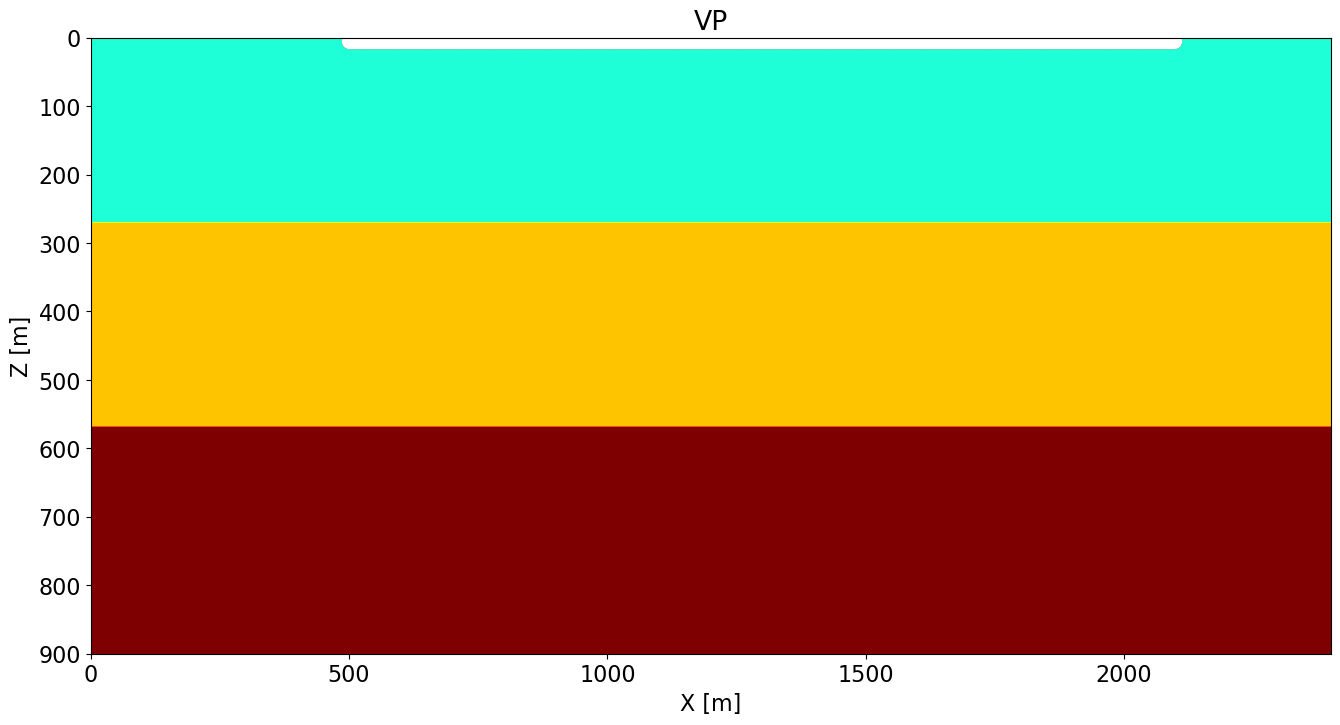

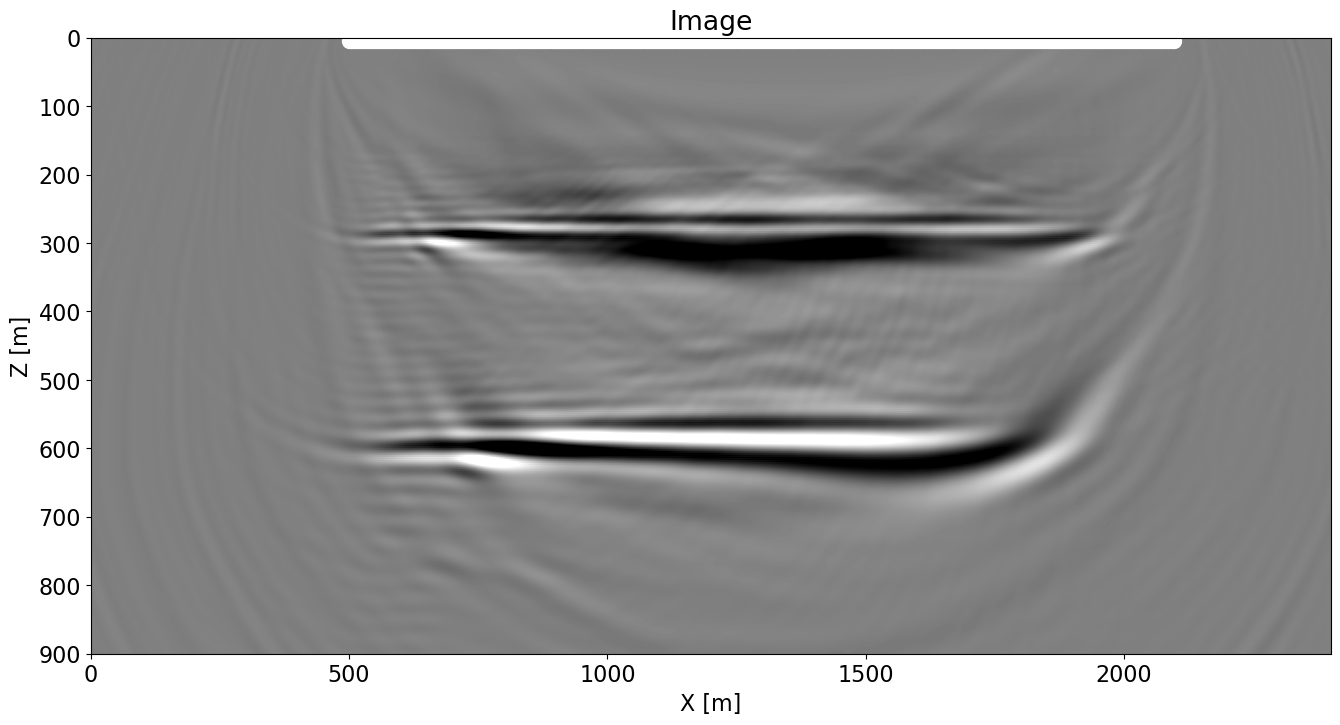

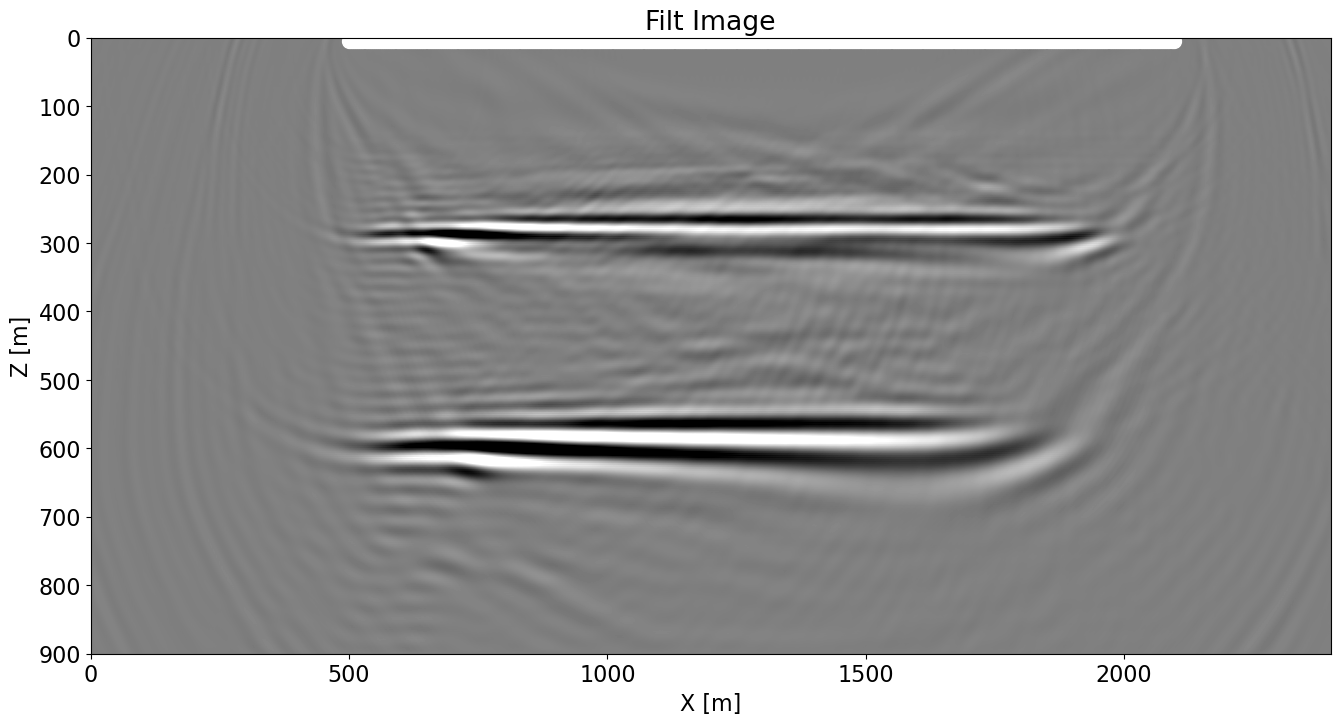

In [28]:
clip = np.abs(image).max() * 0.5
clip_flit = np.abs(imagefilt).max() * 0.5

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(image.T, cmap='gray', vmin=-clip, vmax=clip, 
          interpolation='sinc', extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'Image')
ax.axis('tight')
# ax.set_xlim(3000, 8500)
# ax.set_ylim(4000, 0)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(imagefilt.T, cmap='gray', vmin=-clip_flit, vmax=clip_flit, 
          interpolation='sinc', extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'Filt Image')
ax.axis('tight')
# ax.set_xlim(3000, 8500)
# ax.set_ylim(4000, 0);

(0.0, 2400.0, 900.0, 0.0)

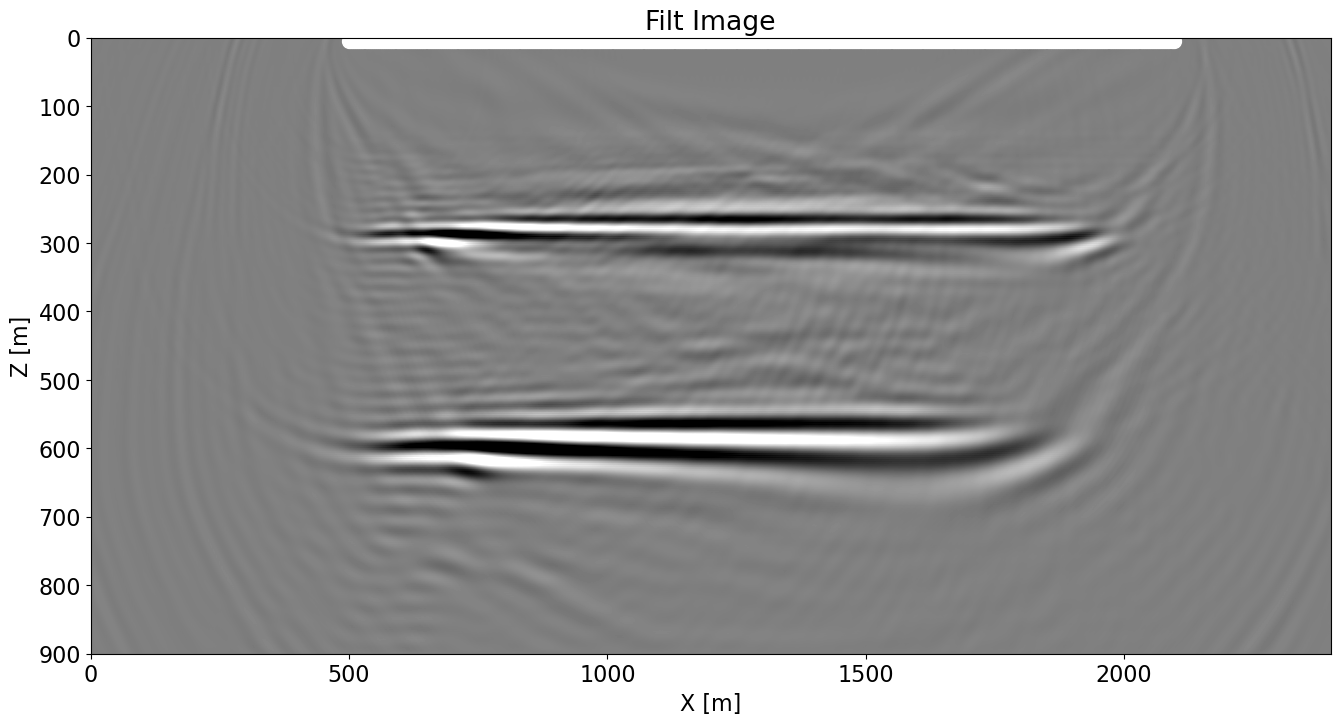

In [29]:
# artifact removal
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
imagefilt = image - filtfilt(smooth,1,filtfilt(smooth,1,image).T).T

clip_flit = np.abs(imagefilt).max() * 0.5

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(imagefilt.T, cmap='gray', vmin=-clip_flit, vmax=clip_flit, 
          interpolation='sinc', extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'Filt Image')
ax.axis('tight')
# ax.set_xlim(3000, 8500)
# ax.set_ylim(4000, 0);

(0.0, 2400.0, 900.0, 0.0)

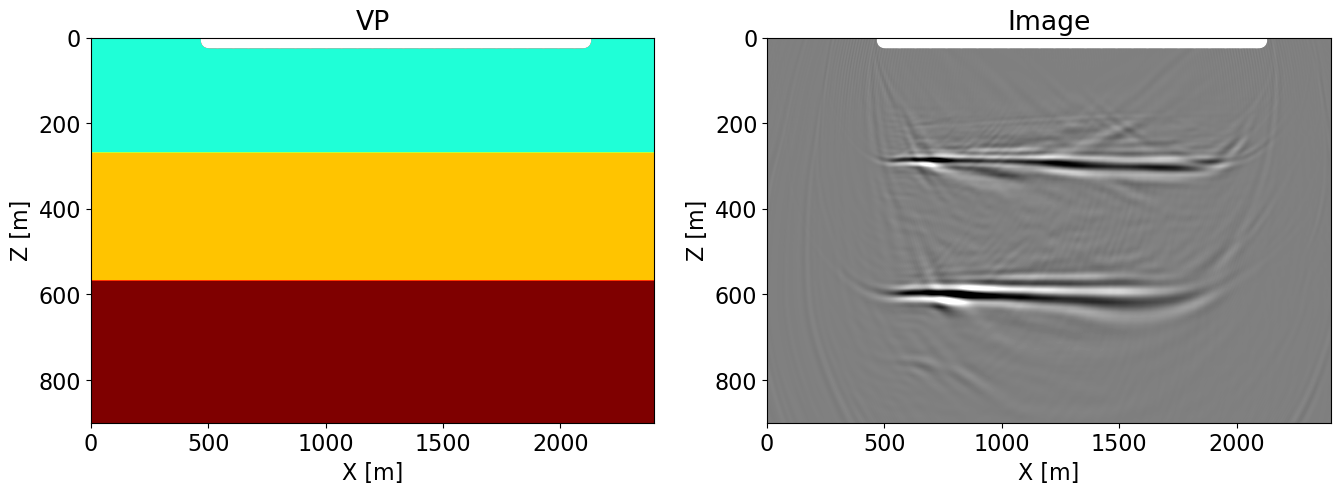

In [50]:
# artifact removal mdd
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
imagefilt = image - filtfilt(smooth,1,filtfilt(smooth,1,image).T).T

clip_flit = np.abs(imagefilt).max() * 0.5

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')

ax1.imshow(imagefilt.T, cmap='gray', vmin=-clip_flit, vmax=clip_flit, 
          interpolation='sinc', extent=(x[0], x[-1], z[-1], z[0]))
ax1.plot(r[0], r[1], '.w', ms=20)
ax1.set_xlabel(r'X [m]')
ax1.set_ylabel(r'Z [m]')
ax1.set_title(r'Image')
ax1.axis('tight')
# ax1.set_xlim(3000, 8500)
# ax1.set_ylim(4000, 0);

(0.0, 2400.0, 900.0, 0.0)

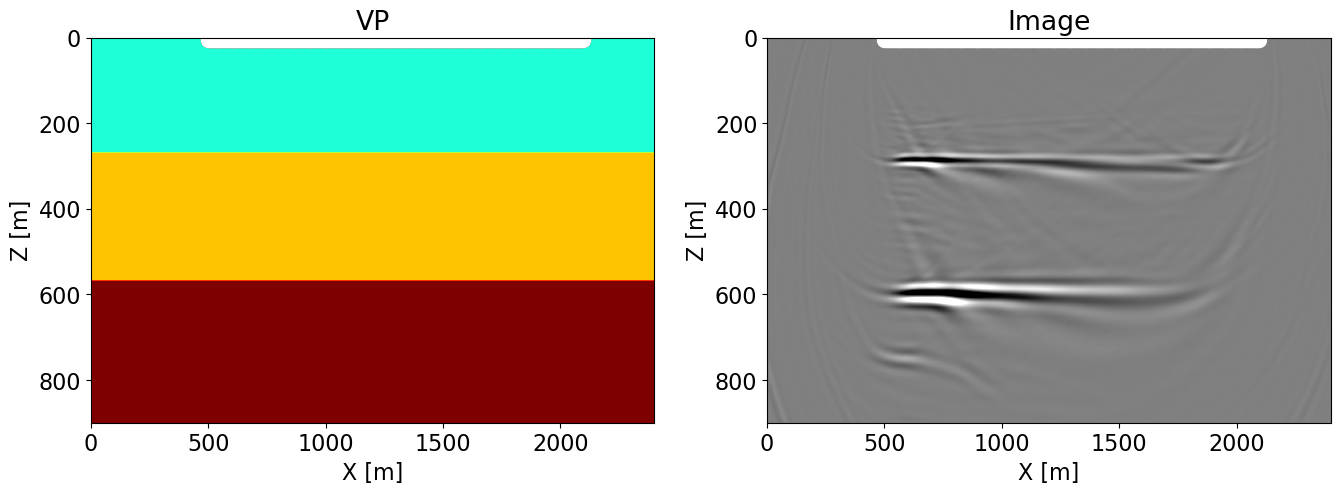

In [30]:
# artifact removal cor
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
imagefilt_cor = image_cor - filtfilt(smooth,1,filtfilt(smooth,1,image_cor).T).T

clip_flit_cor = np.abs(imagefilt_cor).max() * 0.5

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')

ax1.imshow(imagefilt_cor.T, cmap='gray', vmin=-clip_flit_cor, vmax=clip_flit_cor, 
          interpolation='sinc', extent=(x[0], x[-1], z[-1], z[0]))
ax1.plot(r[0], r[1], '.w', ms=20)
ax1.set_xlabel(r'X [m]')
ax1.set_ylabel(r'Z [m]')
ax1.set_title(r'Image')
ax1.axis('tight')
# ax1.set_xlim(3000, 8500)
# ax1.set_ylim(4000, 0);